# Will a business experience acheive a higher amount of reviews based on the number of transactions it provides?

> **Explain**

In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.oauth2 import service_account
from google.cloud import bigquery
import configparser

To begin we'll have to run a new sql script to get data from Big Query aside from the other data we've already serialized on our local filesystem.

In [2]:
KEY_PATH = "/mnt/c/Users/Ron/git-repos/yelp-data/gourmanddwh-f75384f95e86.json"
CREDS = service_account.Credentials.from_service_account_file(KEY_PATH)
client = bigquery.Client(credentials=CREDS, project=CREDS.project_id)


In [4]:
transactions_file = open('sql_scripts/business_transactions.sql','r')
tran_query =  transactions_file.read()

business_transactions_dataframe = (
    client.query(tran_query)
    .result()
    .to_dataframe()
)

In [9]:
business_transactions_dataframe.to_parquet('business_transactions.snappy.parquet', 'pyarrow','snappy', partition_cols=['transactions_list'])


In [14]:
holding_file = open('sql_scripts/business_daily_holding.sql')
holding_query = holding_file.read()

holding_dataframe : pd.DataFrame = (
    client.query(holding_query)
    .result()
    .to_dataframe()
)

In [15]:
holding_dataframe.to_parquet('bus_holdings.snappy.parquet', 'pyarrow','snappy', partition_cols=['CloseDate'])


In [16]:
cg_df = pd.read_parquet('cg_est', engine='pyarrow')
bh_df: pd.DataFrame = pd.read_parquet('bus_holdings.snappy.parquet', engine='pyarrow')
bus_cats_df = pd.read_parquet('bus_cats', engine='pyarrow')
bt_df = pd.read_parquet('business_transactions.snappy.parquet', engine='pyarrow')


Our new dataset aggregates the number of transactions for each business and also concatenates the ones that a business has listed with a '**,**' as a separator.\
The data was partioned which is why it is loaded in the way it was. \
Concerning the transaction values themselves there are some businesses who haven't reported any. In this case we opted to just fill in the value other but have kept their transactions count as 0.

> Note: Concerning the transactions it seems to be 0 just indicates any regular business outside of the food industry or those that require their customers to come inside to place orders and then carry their food out. For more infromation see the following on [transactions](https://www.yelp.com/developers/documentation/v3/business_search)


In [17]:
bt_df

,BusinessKey,BusinessName,transactioncounts,transactions_list
0,35,scott-street-deli-montgomery,1,delivery
1,88,satori-coffee-house-mobile,1,delivery
2,986,international-house-of-hotdogs-anchorage,1,delivery
3,1785,wills-cinnamon-shop-hot-springs-2,1,delivery
4,1821,capos-tacos-hot-springs,1,delivery
...,...,...,...,...
63312,59447,mycovios-ocean-park-2,1,restaurant_reservation
63313,32560,d-h-lescombes-winery-and-bistro-alamogordo,1,restaurant_reservation
63314,33115,medley-el-prado,1,restaurant_reservation
63315,5103,the-pullman-glenwood-springs,1,restaurant_reservation


As seen in previous analyses and just from some domain knowledge, we know that the distribution of review counts is going to be right skewed. 

In [19]:
# the values are partitioned on the close date so there is no need for us to sort the data
most_recent_bh_df = bh_df.drop_duplicates(subset='BusinessName', keep='last')


In [37]:
most_recent_bh_df = most_recent_bh_df.reset_index(drop=True)
most_recent_bh_df

,BusinessKey,BusinessName,ChainName,BusinessRating,ReviewCount,previous_review_cnt,previous_rating,abs_review_diff,abs_rating_diff,total_review_cnt_delta,total_bus_rating_delta,CloseDate
0,18065,hog-wild-pit-bar-b-q-salina,Hog Wild Pit Bar-B-Q,4.000000000,66,NaN,None,NaN,None,NaN,None,2021-12-29
1,27043,mr-bs-frozen-treats-laurel,Mr Bs Frozen Treats,5.000000000,8,NaN,None,NaN,None,NaN,None,2021-12-29
2,27040,small-coffee-big-taste-laurel-2,Small Coffee Big Taste,4.500000000,14,NaN,None,NaN,None,NaN,None,2021-12-29
3,25441,white-horse-st-cloud-2,The White Horse Restaurant & Bar,4.000000000,208,NaN,None,NaN,None,NaN,None,2021-12-29
4,53160,deutschlander-buffalo-gap-2,Deutschlander,4.000000000,37,37.0,4.000000000,0.0,0E-9,0.0,0E-9,2022-01-14
...,...,...,...,...,...,...,...,...,...,...,...,...
63312,23543,zzs-sports-bar-and-grill-adrian,ZZ's Sports Bar & Grill,3.500000000,10,10.0,3.500000000,0.0,0E-9,-60.0,0E-9,2022-02-27
63313,5467,zzzz-s-pizzzza-burlington,ZZZZ’s PIzzzza,5.000000000,1,1.0,5.000000000,0.0,0E-9,-1.0,0.500000000,2022-02-27
63314,13045,àlavita-boise-2,ÀLAVITA,4.000000000,308,309.0,4.000000000,-1.0,0E-9,55.0,-0.500000000,2022-02-27
63315,44974,ándale-caguas-2,Ándale,5.000000000,3,3.0,5.000000000,0.0,0E-9,0.0,0E-9,2022-02-27


The histogram of the data shows this as well as the kernal density estimate.

array([[<AxesSubplot:title={'center':'ReviewCount'}>]], dtype=object)

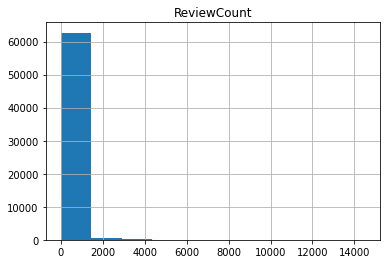

In [39]:
most_recent_bh_df.hist('ReviewCount', bins=10)

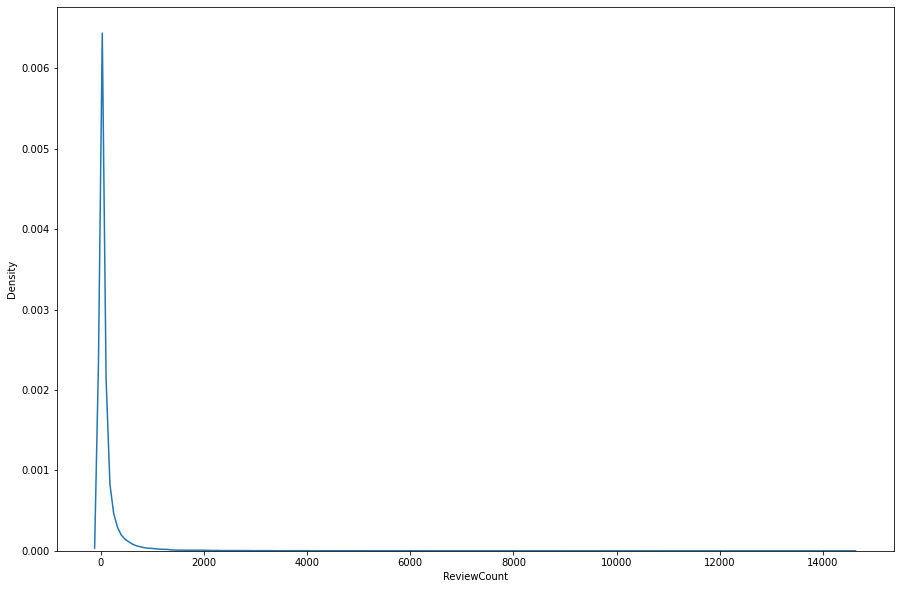

In [40]:
plt.figure(figsize=(15, 10))
sns.kdeplot(most_recent_bh_df['ReviewCount'])
plt.show()

A more granular look at the data reveals the same as well.

In [42]:
most_recent_bh_df['ReviewCount'].value_counts(normalize=True ,bins=10)

(-14.514, 1451.3]     0.989813
(1451.3, 2902.6]      0.007233
(2902.6, 4353.9]      0.001737
(4353.9, 5805.2]      0.000727
(7256.5, 8707.8]      0.000190
(5805.2, 7256.5]      0.000174
(8707.8, 10159.1]     0.000063
(10159.1, 11610.4]    0.000032
(13061.7, 14513.0]    0.000032
(11610.4, 13061.7]    0.000000
Name: ReviewCount, dtype: float64

With such skew we would ideally take some sort of transformation of this variable whether it be the natural log or some higher-order polynomial, etc.\
But before doing so it may be best to look at the joint distribtuion of our 2 variables ,namely, `transaction counts` and `review counts`.

We'll just merge out data first.

In [47]:
most_recent_bh_tran_df = pd.merge(left=most_recent_bh_df, right=bt_df, on='BusinessKey', how='inner')
most_recent_bh_tran_df.head()

,BusinessKey,BusinessName_x,ChainName,BusinessRating,ReviewCount,previous_review_cnt,previous_rating,abs_review_diff,abs_rating_diff,total_review_cnt_delta,total_bus_rating_delta,CloseDate,BusinessName_y,transactioncounts,transactions_list
0,18065,hog-wild-pit-bar-b-q-salina,Hog Wild Pit Bar-B-Q,4.000000000,66,NaN,None,NaN,None,NaN,None,2021-12-29,hog-wild-pit-bar-b-q-salina,1,delivery
1,27043,mr-bs-frozen-treats-laurel,Mr Bs Frozen Treats,5.000000000,8,NaN,None,NaN,None,NaN,None,2021-12-29,mr-bs-frozen-treats-laurel,0,other
2,27040,small-coffee-big-taste-laurel-2,Small Coffee Big Taste,4.500000000,14,NaN,None,NaN,None,NaN,None,2021-12-29,small-coffee-big-taste-laurel-2,0,other
3,25441,white-horse-st-cloud-2,The White Horse Restaurant & Bar,4.000000000,208,NaN,None,NaN,None,NaN,None,2021-12-29,white-horse-st-cloud-2,1,delivery
4,53160,deutschlander-buffalo-gap-2,Deutschlander,4.000000000,37,37.0,4.000000000,0.0,0E-9,0.0,0E-9,2022-01-14,deutschlander-buffalo-gap-2,0,other


<AxesSubplot:xlabel='transactioncounts', ylabel='ReviewCount'>

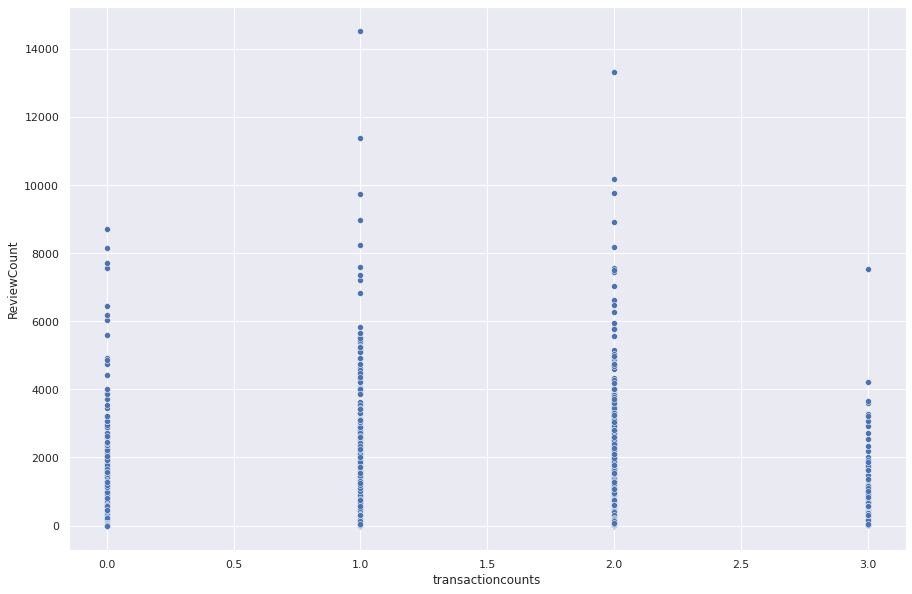

In [53]:
sns.set_theme()
plt.figure(figsize=(15, 10))
sns.scatterplot(x=most_recent_bh_tran_df['transactioncounts'], y=most_recent_bh_tran_df['ReviewCount'], x_jitter=.30)

Basándonos en esta imagen se puede ver que la mejor forma de transformar la cantidad de revistas sería tomar el polynomial, y para ser mas preciso una tranformación de la siguiente forma $$x^2$$ \
Esto es porque el la distribución empieza a subir y luego comienza a bajar después de llegar a una sola transacción.\
El único problema es que este es el variable dependiente así que nos conformamos con tomar el log que tambien puede ayudar. \
El otro problema viene siendo que tambien tenemos cero en este variable.

In [43]:
most_recent_bh_df['ReviewCount'].nsmallest(10)

10853    0
23413    0
24761    0
25502    0
40924    0
51025    0
25       1
38       1
40       1
47       1
Name: ReviewCount, dtype: int64

Ya que no hay una cantidad impresionante de ceros podemos botarlos, solo hay seis.

> **Al regrasar sigue quitando los ceros, transformarlo, y piensa en hacer otro proyecto con total review change and review changes (mas complejo)**